In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve,roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

tc_df=pd.read_csv('Telco-Customer-Churn-Data.csv')

In [3]:
tc_df['TotalCharges'].replace(' ',np.NaN,inplace=True)##Replaing spaces(string) into missing value to avoid errors in convert to float
tc_df['TotalCharges']=tc_df['TotalCharges'].astype(float)
# convert this cat col in data set to cont 

In [4]:
tc_df['SeniorCitizen']=tc_df['SeniorCitizen'].astype(object)
# convert this con col in data set to catg 

In [5]:
corr_cols_df=tc_df.copy()
corr_cat_cols=[col for col in corr_cols_df.columns if corr_cols_df[col].dtype=='object'] 
corr_cont_cols=[col for col in corr_cols_df.columns if corr_cols_df[col].dtype=='int64' or corr_cols_df[col].dtype=='float64']

for col in corr_cont_cols:###Relacing MIss values with mean for total column just to avoid nan in finding p_values
    corr_cols_df[col].fillna(corr_cols_df[col].mean(),inplace=True)
for col in corr_cat_cols:
    corr_cols_df[col].fillna(corr_cols_df[col].mode(),inplace=True)


In [19]:
def chi_squ(col):
    contigency_table=pd.crosstab(corr_cols_df[col],corr_cols_df['Churn'])
    res=chi2_contingency(contigency_table)
    return res[1],col

data=[chi_squ(col) for col in corr_cat_cols]

cat_chi_sq_df=pd.DataFrame(data,columns =['p_value', 'col_name'])
corr_catg_cols=cat_chi_sq_df[cat_chi_sq_df['p_value'] < 0.05]
corr_catg_col_names=list(corr_catg_cols['col_name']) # Correlated catg columns


In [10]:
catg=corr_cols_df['Churn'].value_counts().index.tolist()

def anova(col):### Anova logic
    res=f_oneway(*[corr_cols_df[corr_cols_df['Churn']==cat][col]for cat in catg])
    return res[1],col

cont_data=[anova(col) for col in corr_cont_cols]
cont_data

#cont_anova_df=pd.DataFrame(cont_data,columns =['value', 'col_name'])
#cont_anova_df['value']=cont_anova_df['value'].fillna(0)
#cont_anova_df

[(7.999057960610892e-205, 'tenure'),
 (2.7066456068950115e-60, 'MonthlyCharges'),
 (4.2338363848907657e-64, 'TotalCharges')]

In [14]:
corr_cont_cols=cont_anova_df[cont_anova_df['value'] < 0.05]
corr_cont_col_names=list(corr_cont_cols['col_name'])
len(corr_cont_col_names)## correlated cont columns
corr_cont_cols

,value,col_name
0,7.999058e-205,tenure
1,2.706646e-60,MonthlyCharges
2,4.233836e-64,TotalCharges


In [15]:
tot_corr_col_names=corr_catg_col_names + corr_cont_col_names

In [20]:
mainfo_df=tc_df.copy()## Creating copy of DF for deleting unwanted columns
mainfo_df.drop(columns=tot_corr_col_names,inplace=True)## Now this DF contains unwanted columns so that it can pass to next step
ls_cols_remove=list(mainfo_df.columns)
ls_cols_remove

['customerID', 'gender', 'PhoneService']

In [25]:
tc_df.drop(columns=ls_cols_remove,inplace=True)

In [27]:
y=tc_df['Churn']
tc_df.drop(columns=['Churn'],inplace=True)

In [28]:
cat_cols=[col for col in tc_df.columns if tc_df[col].dtype=='object']
con_cols=[col for col in tc_df.columns if tc_df[col].dtype=='int64' or tc_df[col].dtype=='float64']


In [29]:
tc_df['TotalCharges'].isnull().sum()

11

In [30]:
mainfo_df_val=pd.DataFrame({'col_name':tc_df.columns,'na_cnt':tc_df.isnull().sum(),'pc_cnt':(tc_df.isnull().sum()/tc_df.shape[0])*100})
mainfo_df_val

,col_name,na_cnt,pc_cnt
SeniorCitizen,SeniorCitizen,0,0.000000
Partner,Partner,0,0.000000
Dependents,Dependents,0,0.000000
tenure,tenure,0,0.000000
MultipleLines,MultipleLines,0,0.000000
InternetService,InternetService,0,0.000000
OnlineSecurity,OnlineSecurity,0,0.000000
OnlineBackup,OnlineBackup,0,0.000000
DeviceProtection,DeviceProtection,0,0.000000
TechSupport,TechSupport,0,0.000000


In [31]:
x_train,x_test,y_train,y_test=train_test_split(tc_df,y,random_state=52,test_size=0.2)

In [32]:
for col in con_cols:
    x_train[col].fillna(x_train[col].mean(),inplace=True)
    x_test[col].fillna(x_train[col].mean(),inplace=True)

In [33]:
for col in cat_cols:
    x_train[col].fillna(x_train[col].mode()[0],inplace=True)
    x_test[col].fillna(x_train[col].mode()[0],inplace=True)

In [34]:
scaler=StandardScaler()

for col in con_cols:
    x_train[col]=scaler.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col]=scaler.transform(np.array(x_test[col]).reshape(-1,1))

In [35]:
cat_encd_train=pd.get_dummies(x_train[cat_cols])
cat_encd_test=pd.get_dummies(x_test[cat_cols])

In [36]:
cat_encd_train_final,cat_encd_test_final=cat_encd_train.align(cat_encd_test,join='inner',axis=1)

In [37]:
x_train_final=pd.concat([x_train[con_cols],cat_encd_train_final],axis=1)

In [38]:
x_test_final=pd.concat([x_test[con_cols],cat_encd_test_final],axis=1)

In [39]:
x_test_final.shape,x_train_final.shape

((1409, 41), (5634, 41))

In [40]:
logreg=LogisticRegression()
logreg.fit(x_train_final,y_train)

LogisticRegression()

In [41]:
y_test_pred=logreg.predict(x_test_final)

In [42]:
confusion_matrix(y_test,y_test_pred)

array([[914, 113],
       [153, 229]], dtype=int64)

In [43]:
precision_score(y_test,y_test_pred,pos_label='Yes')

0.6695906432748538

In [44]:
recall_score(y_test,y_test_pred,pos_label='Yes')

0.599476439790576

In [45]:
f1_score(y_test,y_test_pred,pos_label='Yes')

0.6325966850828729

Text(0.5, 1.0, 'AUC Curve')

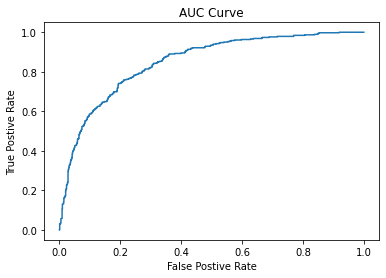

In [46]:
pos_probs=logreg.predict_proba(x_test_final)[::,1]
fpr,tpr,thresold=roc_curve(y_test,pos_probs,pos_label='Yes')
plt.plot(fpr,tpr)
plt.xlabel('False Postive Rate')
plt.ylabel('True Postive Rate')
plt.title('AUC Curve')

In [47]:
roc_auc_score(y_test,pos_probs)

0.8488226267734519